<a href="https://colab.research.google.com/github/sauryanshu55/Speech-Recognition/blob/main/Copy_of_Milestone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speak Feel: Emotion Recognition In Speech   

**Bach Le, Kien Tran, Sauryanshu Khanal, Sike Ogieva**

Emotion Recognition has important applications in natural language processing and human computer interaction.
Here, we build and train a neural network to classify human speech data by emotion.   

Dataset:   
https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio?resource=download

Project Milestones:   
https://github.com/sike25/speak_feel/blob/main/SpeakFeel_%20Emotion%20Recognition%20In%20Speech.pdf

In [ ]:
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

# from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from google.colab import drive
from sklearn.model_selection import train_test_split

## Utility Functions
A range of utility functions

In [ ]:
# Our data is stored in gdrive. I have shared a shared folder with you all with the data. Make sure to add it to your drive.
# Then uncomment the next line, so that Jupyter Notebook has access to your drive
drive.mount('/content/drive')
root_dir='/content/drive/MyDrive/data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

In [ ]:
"""
Create a waveplot of a given wav file
Params: data (from librosa documentation https://librosa.org/doc/main/generated/librosa.load.html, a time-series of floating point numbers representing the audio file)
        sr, Sampling Rate
        filter: Any one value from emotion, or statement or any other attribute
"""
def create_waveplot(data, sr, attribute,value):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {attribute}={value}', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_waveplot_wrapper(attribute,value):
  sample_obs= df[df[attribute] == value].iloc[0]
  sample_path=sample_obs['File_Path']
  data, sampling_rate = librosa.load(sample_path)
  create_waveplot(data, sampling_rate,attribute,value)

"""
Create a spectogram of a given wav file
Params: data (from librosa documentation https://librosa.org/doc/main/generated/librosa.load.html, a time-series of floating point numbers representing the audio file)
        sr, Sampling Rate
        filter: Any one value from emotion, or statement or any other attribute
"""
def create_spectrogram_wrapper(attribute,value):
  sample_obs= df[df[attribute] == value].iloc[0]
  sample_path=sample_obs['File_Path']
  data, sampling_rate = librosa.load(sample_path)
  create_spectrogram(data, sampling_rate,attribute,value)

def create_spectrogram(data, sr,attribute,value):
    # The STFT represents a signal in the time-frequency domain by computing
    # discrete Fourier transforms (DFT) over short overlapping windows
    X = librosa.stft(data) # Source and Example of usage: https://librosa.org/doc/main/generated/librosa.stft.html
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectogram for audio with {attribute}={value}', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()


## Data

Our dataset (the speech-only subset of the RAVDESS) contains 1440 files: 60 trials per actor x 24 actors = 1440. There are 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

Directory Structure:
Our directory structure is in the following manner: <br>
-> Root Directory<br>
    &nbsp;&nbsp;&nbsp;&nbsp;-> Actor01<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
    &nbsp;&nbsp;&nbsp;&nbsp;-> Actor02<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
    &nbsp;&nbsp;&nbsp;&nbsp;-> Actor03<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
    ...<br>
    &nbsp;&nbsp;&nbsp;&nbsp;-> Actor24<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> wav file<br>

The name of each file is coded in the following manner:<br>
Modality (01 = full-AV, 02 = video-only, 03 = audio-only).<br>
Vocal channel (01 = speech, 02 = song).<br>
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).<br>
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.<br>
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").<br>
Repetition (01 = 1st repetition, 02 = 2nd repetition).<br>
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).<p>
The code below converts this into Python code, and eventually into a Pandas Dataframe

In [ ]:
emotion, intensity, statement, repetition, actor, gender, path, name = [], [], [], [], [], [], [], []

emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised'] # Possible values in 'emotion_list' feature
intensity_list = ['normal', 'strong'] # Possible values in 'intensity' feature
statement_list = ['kids', 'dogs'] # Possible values in 'statement_list' feature

# Get all sub directories from root directory
dir_list = os.listdir(root_dir)

# for all sub directories in root directory
for dir in dir_list:
    files = os.listdir(root_dir + dir) # All the 'wav' files in that sub-directory

    # For each of those wav files, extract relevant information from their metadata
    for file_name in files:
        # Split the filename into parts
        parts = file_name.split('.')[0].split('-')

        name.append(file_name) #file na,e
        emotion.append(emotion_list[int(parts[2]) - 1]) # Emotion
        intensity.append(intensity_list[int(parts[3]) - 1]) #Intensity
        statement.append(statement_list[int(parts[4]) - 1]) #Statement
        repetition.append(int(parts[5])) #Repetitions
        actor.append(int(parts[6])) # Actor number

        # Gender
        if int(parts[6])%2==0: gender.append('male')
        else: gender.append('female')

        # Loc of the file (Loc within the GDrive, not relative path)
        path.append(root_dir + 'Actor_'+parts[6]+'/'+file_name)

In [ ]:
# Convert the data into a dataframe
data = {
    'File Name': name,
    'Emotion': emotion,
    'Intensity': intensity,
    'Statement': statement,
    'Repetition': repetition,
    'Actor': actor,
    'Gender': gender,
    'File_Path': path,
}

df = pd.DataFrame(data)

In [ ]:
df.head()

,File Name,Emotion,Intensity,Statement,Repetition,Actor,Gender,File_Path
0,03-01-01-01-02-01-19.wav,neutral,normal,dogs,1,19,female,/content/drive/MyDrive/data/ravdess-emotional-...
1,03-01-02-01-02-02-19.wav,calm,normal,dogs,2,19,female,/content/drive/MyDrive/data/ravdess-emotional-...
2,03-01-02-02-02-01-19.wav,calm,strong,dogs,1,19,female,/content/drive/MyDrive/data/ravdess-emotional-...
3,03-01-01-01-01-02-19.wav,neutral,normal,kids,2,19,female,/content/drive/MyDrive/data/ravdess-emotional-...
4,03-01-02-01-01-01-19.wav,calm,normal,kids,1,19,female,/content/drive/MyDrive/data/ravdess-emotional-...


## Exploratory Data Analysis- Sauryanshu's part
We'll merge part this later on  



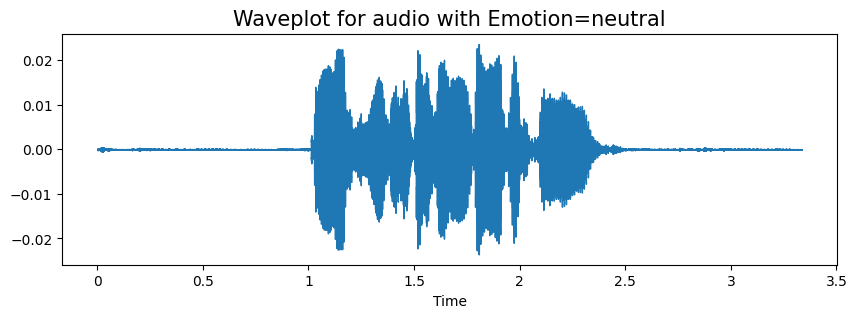

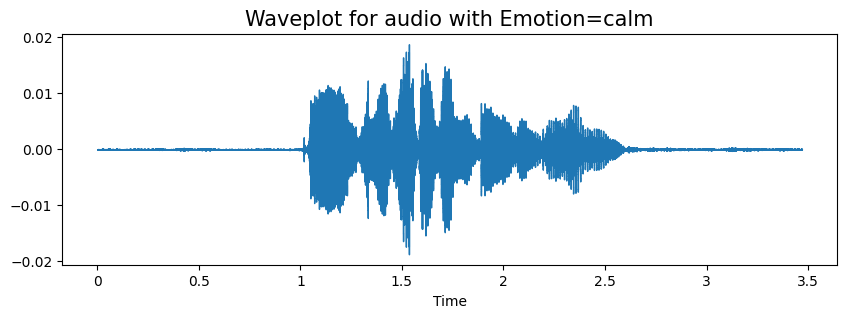

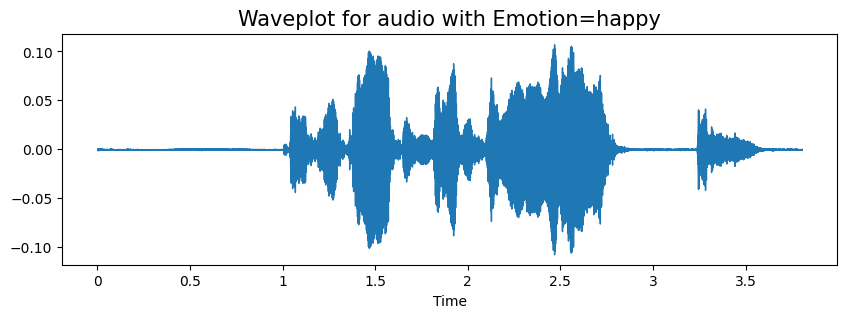

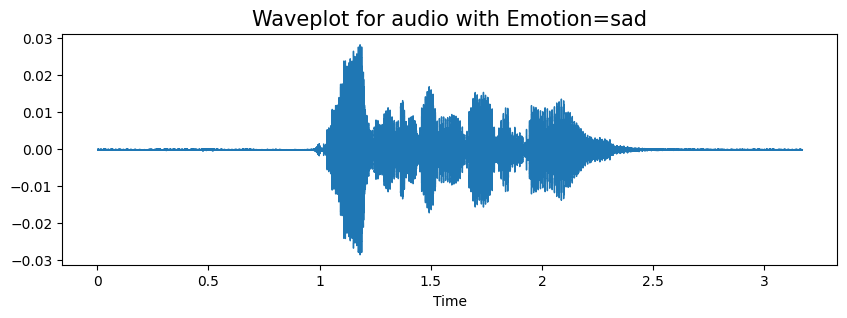

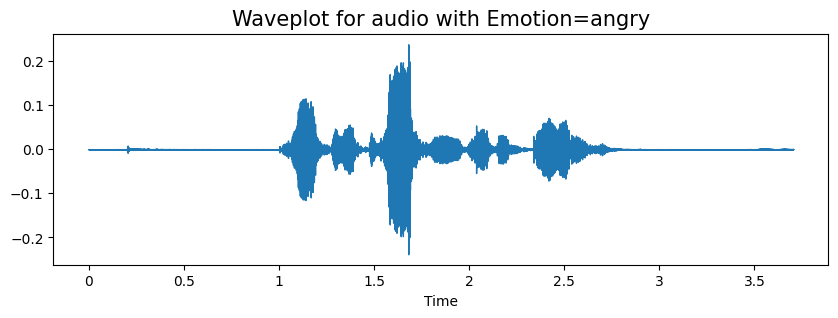

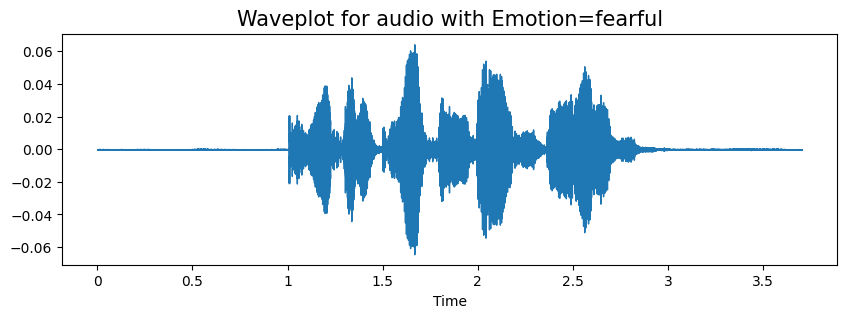

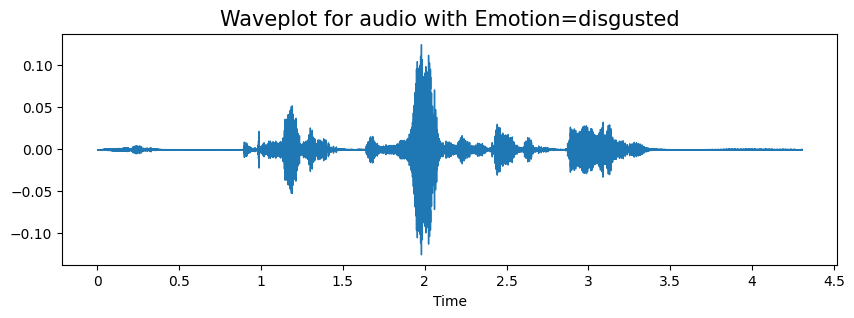

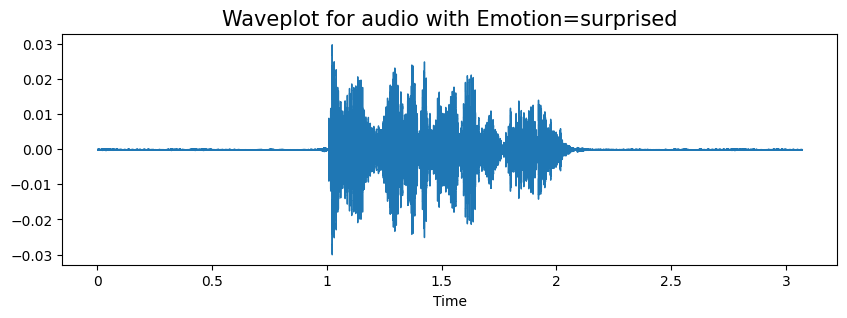

In [ ]:
for emotion in emotion_list:
  create_waveplot_wrapper("Emotion",emotion)

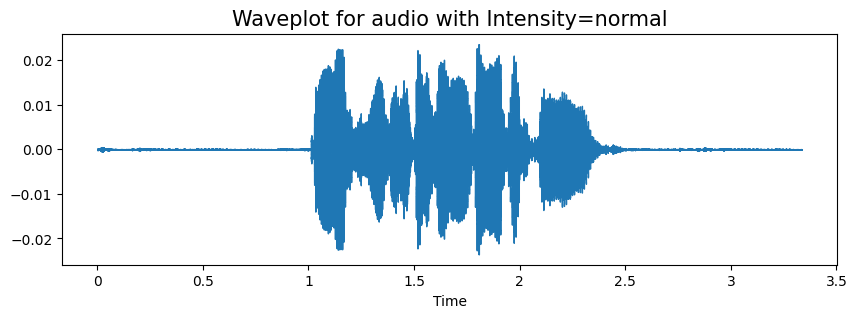

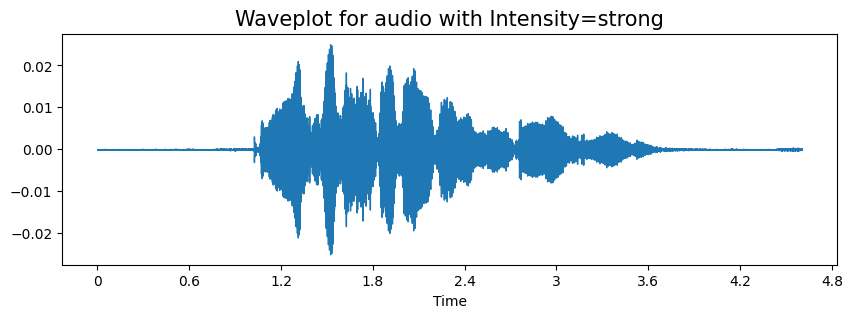

In [ ]:
for intensity in intensity_list:
  create_waveplot_wrapper("Intensity",intensity)

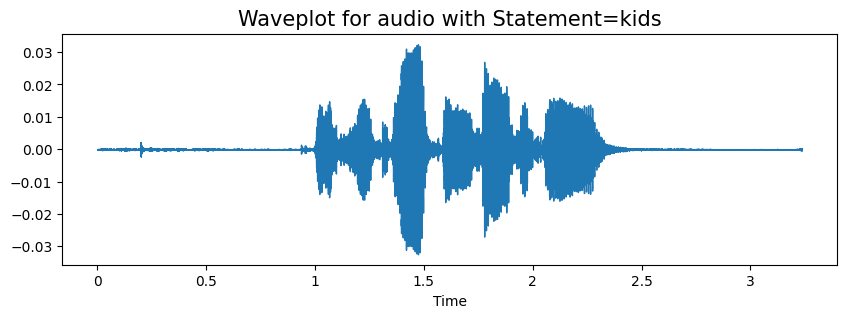

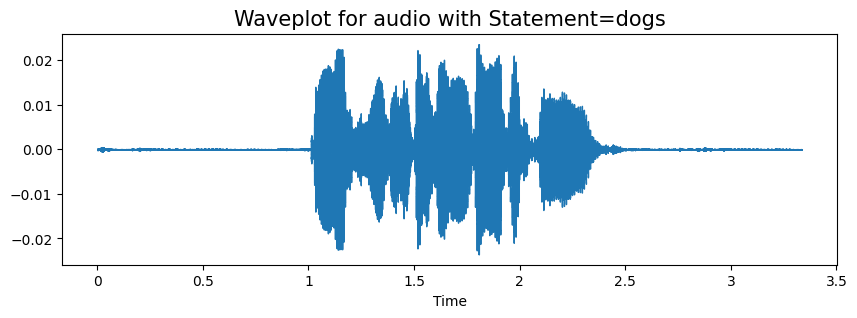

In [ ]:
for statement in statement_list:
  create_waveplot_wrapper("Statement",statement)

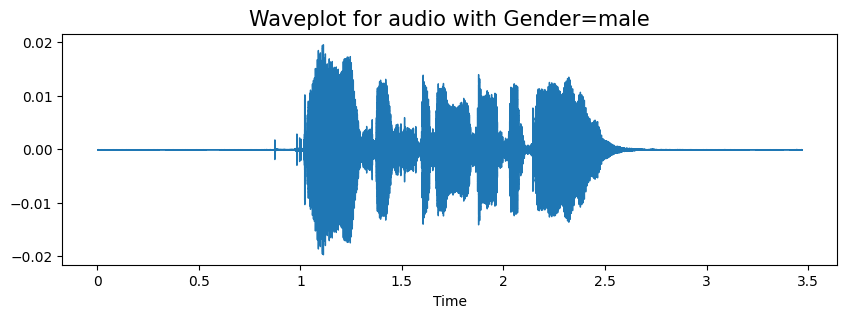

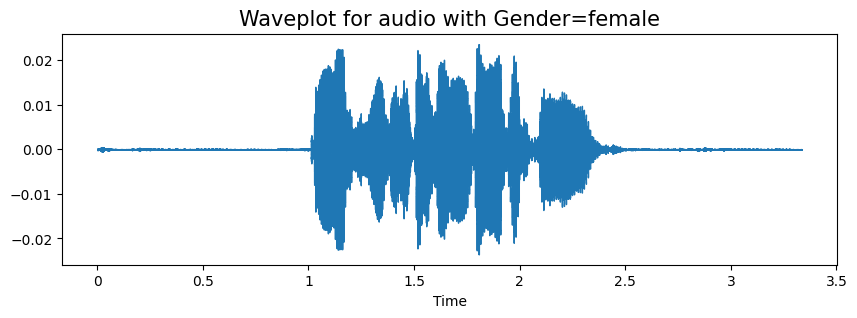

In [ ]:
gender_list=["male","female"]
for gender in gender_list:
  create_waveplot_wrapper("Gender",gender)

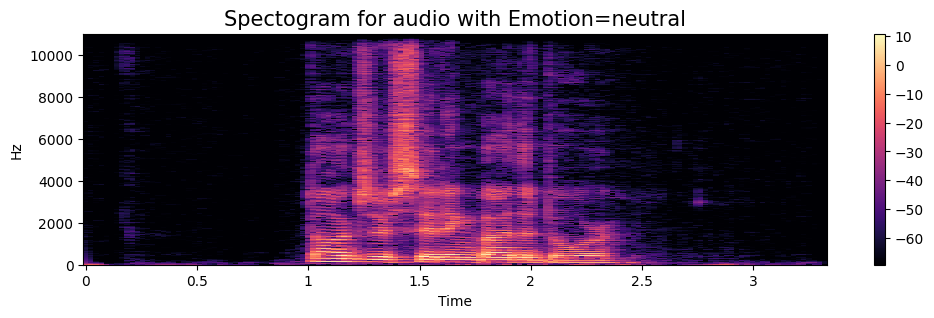

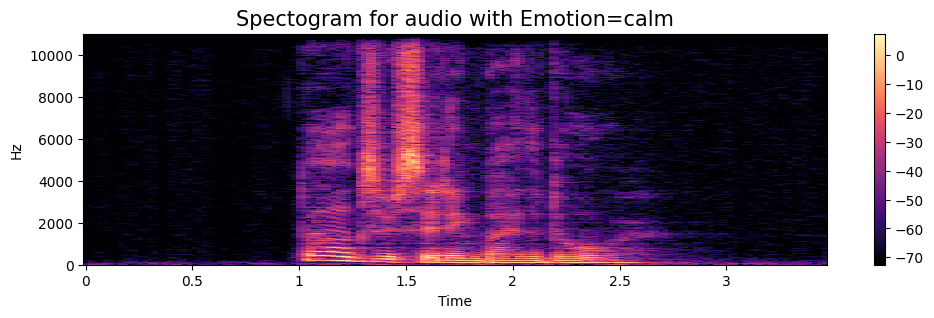

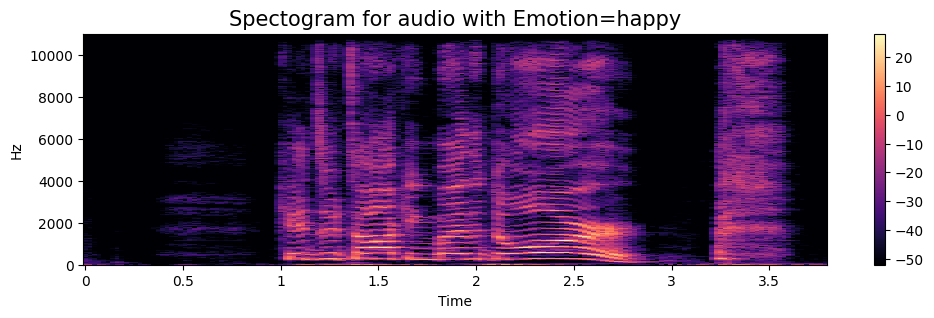

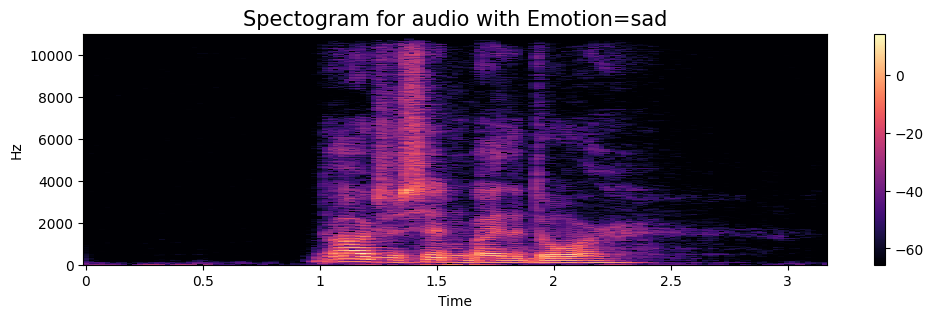

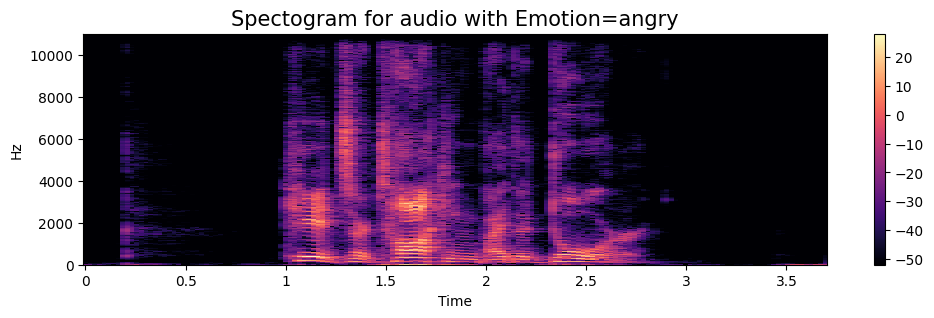

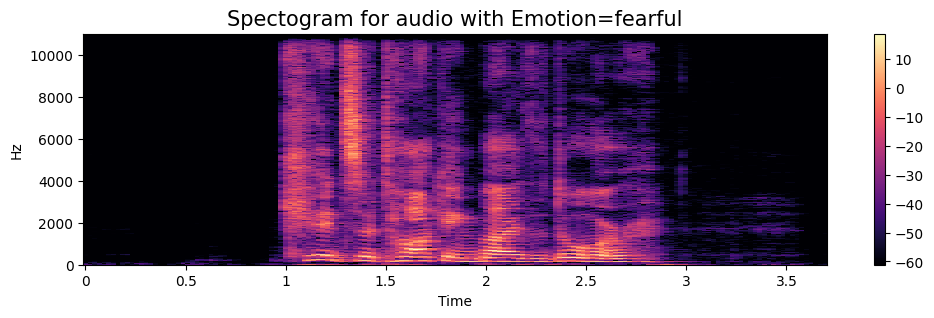

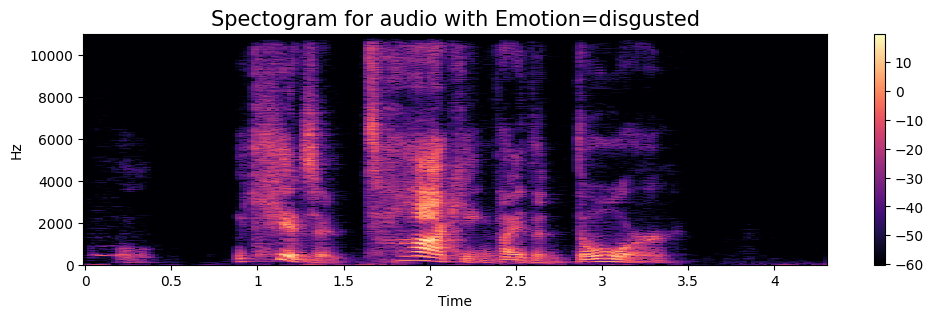

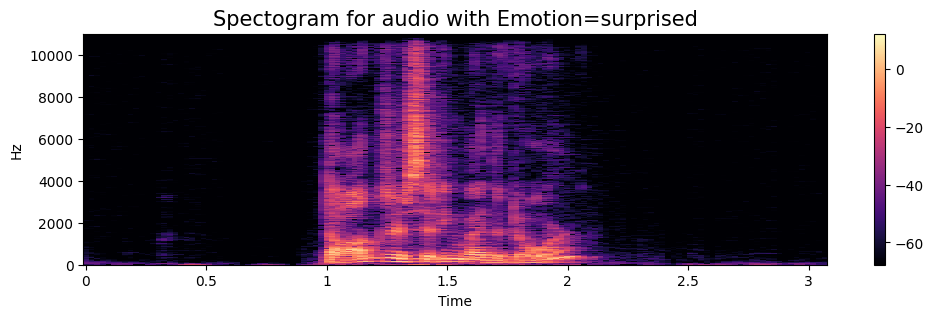

In [ ]:
for emotion in emotion_list:
  create_spectrogram_wrapper("Emotion",emotion)

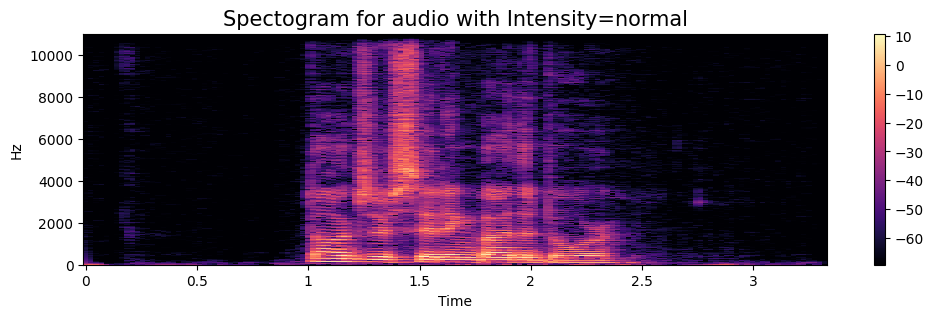

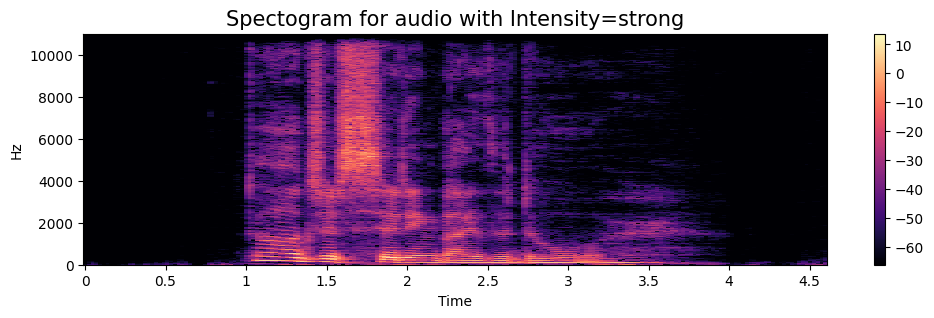

In [ ]:
for intensity in intensity_list:
  create_spectrogram_wrapper("Intensity",intensity)

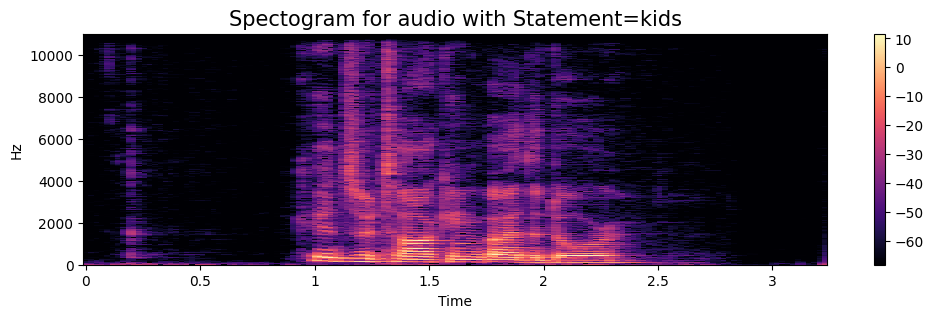

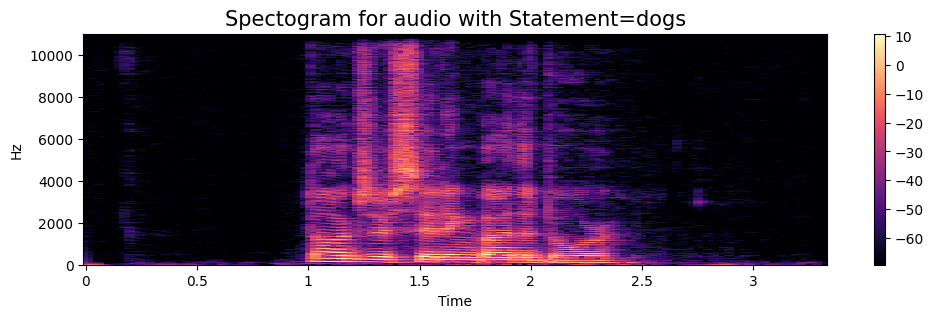

In [ ]:
for statement in statement_list:
  create_spectrogram_wrapper("Statement",statement)

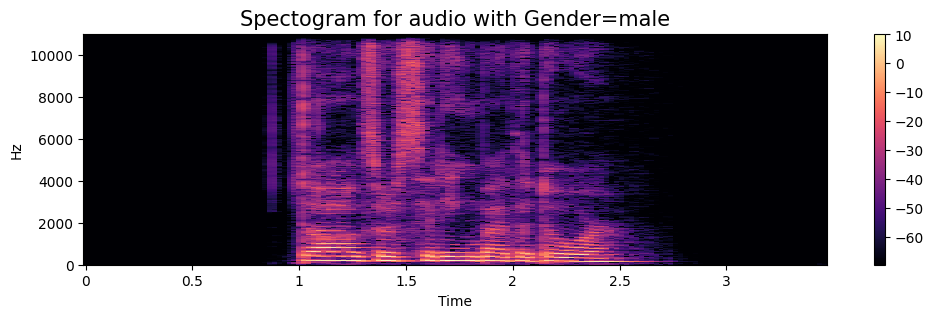

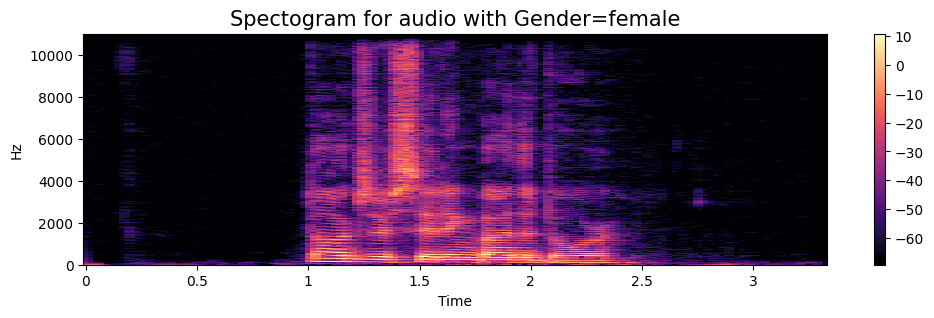

In [ ]:
for gender in gender_list:
  create_spectrogram_wrapper("Gender",gender)

**Citations:**

Data collected from
"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.